### Author: Nathaniel Ruhl
### Date created: 01/29/2021
### Description: This notebook tracks the ISS orbit from the 180 degree point via a low eccentricity orbit in the perifocal frame


In [187]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table

# Read in the mkf file
tab_ni = Table.read('ni2200300102.mkf', hdu=1)
timeMKF = np.array(tab_ni['TIME'])
position = tab_ni['POSITION'] 
position_mag = np.array(np.sqrt((position[:,0])**2+(position[:,1])**2+(position[:,2])**2))
velocity = tab_ni['VELOCITY']
velocity_mag = np.array(np.sqrt((velocity[:,0])**2+(velocity[:,1])**2+(velocity[:,2])**2))

pole_vec = np.cross(position,velocity)
pole_vec_mag = np.array(np.sqrt((pole_vec[:,0])**2+(pole_vec[:,1])**2+(pole_vec[:,2])**2))

# Create unit vectors
for col in range(3):
    velocity[:,col] = velocity[:,col]/velocity_mag
    position[:,col] = position[:,col]/position_mag
    pole_vec[:,col] = pole_vec[:,col]/pole_vec_mag

In [188]:
# Estimated time and position of ISS at the 180 degree point
t_180 = 192223307 # time0_offset-deltaT_50 from feb3_orbit_model.py
RA0 = np.deg2rad(95) # RA_star-180=95, 95+RAAN=167,95-RAAN=23
DEC0 = np.deg2rad(26) # i+delta_star=26, 51.5, -44
# These are different combos of coordinates that exist on the orbit

def RADECtoGEO(alpha, delta):
    x = np.cos(delta)*np.cos(alpha)
    y = np.cos(delta)*np.sin(alpha)
    z = np.sin(delta)
    return np.array([x, y, z])

r0_ECI = RADECtoGEO(RA0, DEC0)
print(r0_ECI)

[-0.07833506  0.89537386  0.43837115]


In [189]:
# Define constants

G = 6.6743*10**(-11) # Nm^2/kg^2, Gravitational constant
R = 6371 #km, known radius of earth
M_earth = 5.972*10**24 # kg, known mass of Earth
mu = G*M_earth # Nm^2/kg, Earth's gravitational parameter
T = 5569.5 # sec, period of ISS orbit directly from convolution
R_orbit = ((T**2)*G*M_earth/(4*np.pi**2))**(1./3) # km, Orbital radius via Kepler's 3rd law
H = (R_orbit - R*10**3)/(10**3) # ~420 km, altitude of ISS orbit
omega_orb = 2 * np.pi / T  # rad/sec
theta = np.arcsin(R/(R+H)) # rad, constant that describes a circular orbit

# Calculate the line of nodes, or apse vector (unit vector), for RAAN
N = np.zeros((len(pole_vec),3))
N_mag = []
for row in range(len(pole_vec)):
    N[row] = np.cross(np.array([0,0,1]),pole_vec_mag[row]*pole_vec[row])
    N_mag.append(np.linalg.norm(N[row]))
    N[row] = N[row]/N_mag[row]
N_mag = np.array(N_mag)

# Calculate the eccentricity unit vector, for the argument of perigee
# we also convert mu from m to km
eccentricity_vec = np.zeros((len(pole_vec),3))
eccentricity_vec_mag = []
for row in range(len(pole_vec)):
    eccentricity_vec[row] = (1./(mu*10**(-6.)))*(np.cross(velocity_mag[row]*velocity[row],pole_vec_mag[row]*pole_vec[row]) - (mu*10**(-6.)*position[row]))
    eccentricity_vec_mag.append(np.linalg.norm(eccentricity_vec))
    eccentricity_vec[row] = eccentricity_vec[row]/eccentricity_vec_mag[row]
eccentricity_vec_mag = np.array(eccentricity_vec_mag)

# Calculate keplerian orbital elements - as constants at the middle index
oldStartMKF = 1880 #2264
oldStopMKF = 2699 #largest range for which data is known around the crossing
middleIndex = int((oldStartMKF+oldStopMKF)/2)

Omega = np.arccos(N[oldStartMKF,0]) # Right ascenion of ascending node
i = np.arccos(pole_vec[oldStartMKF,2]) # inclination of orbit
# This is very intersting - with omega = 0, y is perfect, but with omega = 40, x is perfect. There is also
# a pattern with the relative time offsets of the graphs that don't match
if (eccentricity_vec[oldStartMKF,2]>=0):
    omega = np.arccos(np.dot(N[middleIndex],eccentricity_vec[middleIndex])) # Argument of perigee - this has a big effect on the x and y coordinate
else:
    omega = 2*np.pi - np.arccos(np.dot(N[middleIndex],eccentricity_vec[middleIndex]))
    
omega = np.deg2rad(0) # writing over the previous definition for debugging purposes

print('Keplerian orbital elements on feb 3')
print('RAAN = ' + str(np.rad2deg(Omega)))
print('Inclination = ' + str(np.rad2deg(i)))
print('Argument of perigee = ' + str(np.rad2deg(omega)))

Keplerian orbital elements on feb 3
RAAN = 66.88206676823987
Inclination = 51.557423
Argument of perigee = 0.0


In [190]:
# Define matrix to convert from ECI to perifocal frame

Q = np.array([[np.cos(Omega)*np.cos(omega)-np.sin(Omega)*np.sin(omega)*np.cos(i),np.sin(Omega)*np.cos(omega)+np.cos(Omega)*np.cos(i)*np.sin(omega),np.sin(i)*np.sin(omega)],
             [-np.cos(Omega)*np.sin(omega)-np.sin(Omega)*np.cos(i)*np.cos(omega),-np.sin(Omega)*np.sin(omega)+np.cos(Omega)*np.cos(i)*np.cos(omega),np.sin(i)*np.cos(omega)],
             [np.sin(Omega)*np.sin(i),-np.cos(Omega)*np.sin(i),np.cos(i)]])

In [191]:
# This is a good sign that the z coordinate is zero
r0_Per = np.dot(Q,r0_ECI)/np.linalg.norm(np.dot(Q,r0_ECI))
print(r0_Per)

[ 0.79271783  0.60670527 -0.05922131]


In [192]:
# Create model orbit starting at r0_Per
phi0 = np.arctan2(r0_Per[1],r0_Per[0])
phi = np.arange(phi0,phi0+2*np.pi,omega_orb) # Orbital Phase from 180 degree point to a period later
t = t_180 + (phi/omega_orb) # time array for mkf comparison
print(phi0*180/np.pi)

37.4285764851575


In [195]:
# Propogate the orbit over time, calculating r_Per at every step

r_Per = np.zeros((len(phi),3))

for row in range(len(phi)):
    for col in range(3):
        if (col == 0):
            r_Per[row,col] = np.cos(phi[row]) # x coordinate
        if (col == 1):
            r_Per[row,col] = np.sin(phi[row]) # y coordinate
        if (col == 2):
            r_Per[row,col] = r0_Per[2] # z coordinate, 0 or should we do r0_Per[2] then renormalize ?
    r_Per[row] = r_Per[row]/np.linalg.norm(r_Per[row]) 

# Convert position from perifocal frame to geocentric frame
print(r_Per[0]) # this should be equal to r0_Per         
r_ECI = np.zeros((len(phi),3))

for row in range(len(phi)):
    r_ECI[row] = np.dot(np.matrix.transpose(Q),r_Per[row])
    r_ECI[row] = r_ECI[row]/np.linalg.norm(r_ECI[row]) # This is not really necessary

[ 0.7927227   0.606709   -0.05911773]


Below, we're comparing what we calculate in the perifocal frame to what we expect to see in the perifocal frame.
The fact the data does not produce $\overline{z}=0$ in the perifocal frame tells us that there is a problem with the transformation between ECI and Perifocal. This is either a mistake in the calculation of the keplerian orbital elements and/or a typo in the Q matrix.

In [198]:
expected_perifocal = np.zeros((len(position),3))
for row in range(len(position)):
    expected_perifocal[row]=np.dot(Q,position[row])

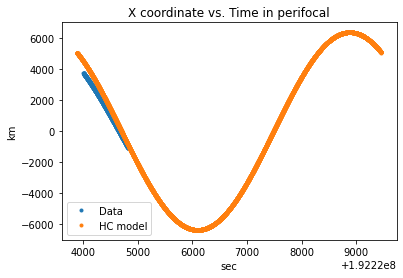

In [199]:
plt.title('X coordinate vs. Time in perifocal')
plt.plot(timeMKF[oldStartMKF:oldStopMKF],position_mag[oldStartMKF:oldStopMKF]*expected_perifocal[oldStartMKF:oldStopMKF,0],'.',label='Data')
plt.plot(t,R*r_Per[:,0],'.',label='HC model')
plt.ylabel('km')
plt.xlabel('sec')
plt.legend()

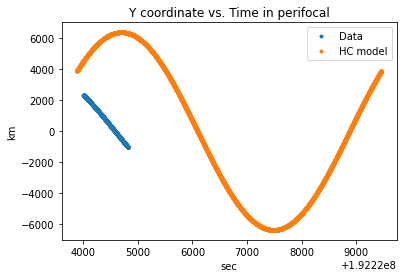

In [200]:
plt.title('Y coordinate vs. Time in perifocal')
plt.plot(timeMKF[oldStartMKF:oldStopMKF],position_mag[oldStartMKF:oldStopMKF]*expected_perifocal[oldStartMKF:oldStopMKF,1],'.',label='Data')
plt.plot(t,R*r_Per[:,1],'.',label='HC model')
plt.ylabel('km')
plt.xlabel('sec')
plt.legend()

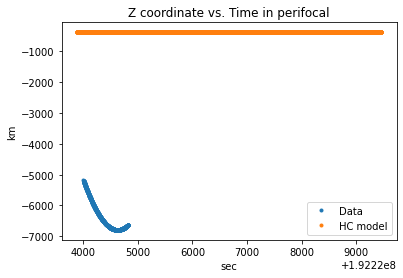

In [201]:
plt.title('Z coordinate vs. Time in perifocal')
plt.plot(timeMKF[oldStartMKF:oldStopMKF],position_mag[oldStartMKF:oldStopMKF]*expected_perifocal[oldStartMKF:oldStopMKF,2],'.',label='Data')
plt.plot(t,R*r_Per[:,2],'.',label='HC model')
plt.ylabel('km')
plt.xlabel('sec')
plt.legend()

Below, we do the comparison in the ECI frame, as this is probably how we would report our findings

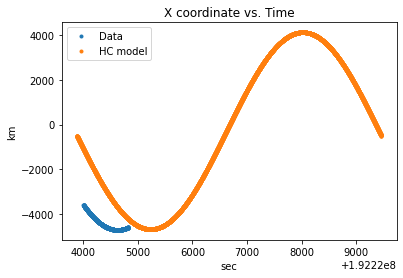

In [203]:
plt.title('X coordinate vs. Time')
plt.plot(timeMKF[oldStartMKF:oldStopMKF],position_mag[oldStartMKF:oldStopMKF]*position[oldStartMKF:oldStopMKF,0],'.',label='Data')
plt.plot(t,R*r_ECI[:,0],'.',label='HC model')
plt.ylabel('km')
plt.xlabel('sec')
plt.legend()

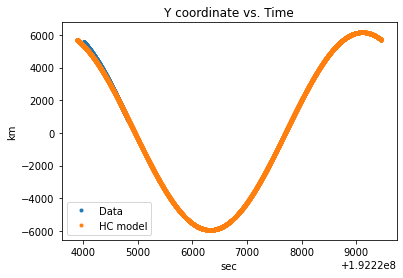

In [204]:
plt.title('Y coordinate vs. Time')
plt.plot(timeMKF[oldStartMKF:oldStopMKF],position_mag[oldStartMKF:oldStopMKF]*position[oldStartMKF:oldStopMKF,1],'.',label='Data')
plt.plot(t,R*r_ECI[:,1],'.',label='HC model')
plt.ylabel('km')
plt.xlabel('sec')
plt.legend()

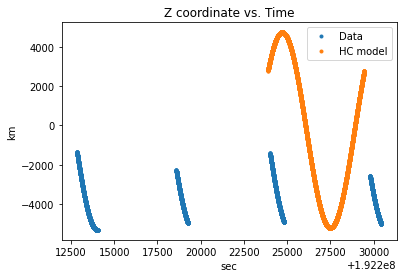

In [205]:
plt.title('Z coordinate vs. Time')
plt.plot(timeMKF,position_mag*position[:,2],'.',label='Data')
plt.plot(t,R*r_ECI[:,2],'.',label='HC model')
plt.ylabel('km')
plt.xlabel('sec')
plt.legend()

Text(0.5, 1.0, 'Normalization of Position Unit Vector')

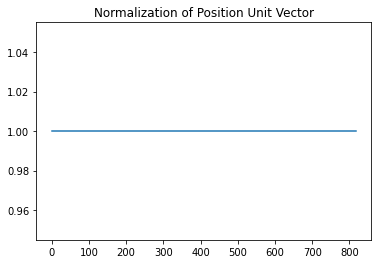

In [206]:
# check that the model is normalized
model_mag = []
for row in range(len(timeMKF[oldStartMKF:oldStopMKF])):
    model_mag.append(np.linalg.norm(r_ECI[row,:]))
plt.plot(model_mag)
plt.title('Normalization of Position Unit Vector')

In [207]:
t1_index_model = np.where(t>timeMKF[oldStartMKF])[0][0] # t1 index when the model meets up with the data at oldStartMKF

In [208]:
print('Accuracy of model at t1:')
print('X: ' + str(int(np.abs(position_mag[oldStartMKF]*position[oldStartMKF,0]-R*r_ECI[t1_index_model,0]))) + 'km')
print('Y: ' + str(int(np.abs(position_mag[oldStartMKF]*position[oldStartMKF,1]-R*r_ECI[t1_index_model,1]))) + 'km')
print('Z: ' + str(int(np.abs(position_mag[oldStartMKF]*position[oldStartMKF,2]-R*r_ECI[t1_index_model,2]))) + 'km')

Accuracy of model at t1:
X: 2510km
Y: 249km
Z: 4707km


Text(0.5, 0, 'sec')

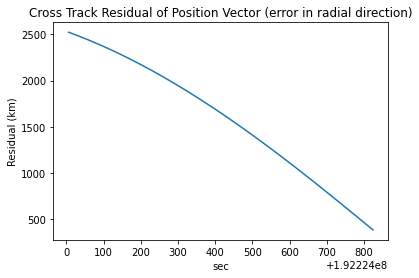

In [209]:
# calculate 'cross track' position resisuduals in km (component of position residual parralel to the nadir line)
position_resids_vec = np.zeros((len(phi)-t1_index_model,3))
crossTrack_resid = []

for row in range(len(timeMKF[oldStartMKF:oldStopMKF])):
    for col in range(3):
        # Error in each X, Y, Z component of the position
        position_resids_vec[row,col] = R*r_ECI[t1_index_model+row,col]-position_mag[oldStartMKF+row]*position[oldStartMKF+row,col]
    # total cross track residual (radial distance)
    crossTrack_resid.append(np.sqrt(position_resids_vec[row,0]**2+position_resids_vec[row,1]**2))

plt.plot(timeMKF[oldStartMKF:oldStopMKF],crossTrack_resid)
plt.title('Cross Track Residual of Position Vector (error in radial direction)')
plt.ylabel('Residual (km)')
plt.xlabel('sec')

Text(0.5, 0, 'sec')

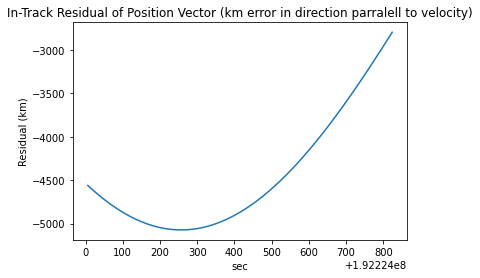

In [210]:
# calculate 'in track' position resisuduals in km (component of position residual parralel to velocity)
inTrack_resid = []
for row in range(len(timeMKF[oldStartMKF:oldStopMKF])):
    inTrack_resid.append(np.dot(velocity[oldStartMKF+row],position_resids_vec[row]))
inTrack_resid = np.array(inTrack_resid)

plt.plot(timeMKF[oldStartMKF:oldStopMKF],inTrack_resid)
plt.title('In-Track Residual of Position Vector (km error in direction parralell to velocity)')
plt.ylabel('Residual (km)')
plt.xlabel('sec')

Text(0.5, 0, 'sec')

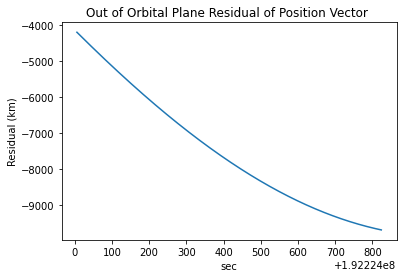

In [211]:
outOfPlane_resid = []
for row in range(len(timeMKF[oldStartMKF:oldStopMKF])):
    outOfPlane_resid.append(position_mag[row]*position[oldStartMKF+row][2]-R*r_ECI[row][2])
outOfPlane_resid = np.array(outOfPlane_resid)

plt.plot(timeMKF[oldStartMKF:oldStopMKF],outOfPlane_resid)
plt.title('Out of Orbital Plane Residual of Position Vector ')
plt.ylabel('Residual (km)')
plt.xlabel('sec')

In [212]:
# Calculate linear velocity at each step
v_ECI = np.zeros((len(phi),3))
for col in range(3):
    for row in range(len(r_ECI)-1):
        v_ECI[row,col] = r_ECI[row+1,col]-r_ECI[row,col] # divided by one second

v_ECI = np.delete(v_ECI,len(phi)-1,axis=0) # delete the last row, which is all zeros

#Normalize the unit vectors
for row in range(len(phi)-1):
    v_ECI[row,:] = v_ECI[row]/np.linalg.norm(v_ECI[row,:])

In [213]:
# Calculate residual corresponding to orbital plane (should be a constant? z_ECI-z_Per). Still need to do this.

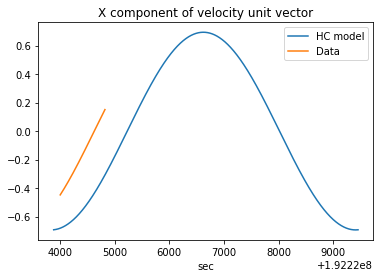

In [214]:
plt.title('X component of velocity unit vector')
plt.plot(t[0:len(t)-1],v_ECI[:,0], label='HC model')
plt.plot(timeMKF[oldStartMKF:oldStopMKF],velocity[oldStartMKF:oldStopMKF,0],label='Data')
plt.xlabel('sec')
plt.legend()

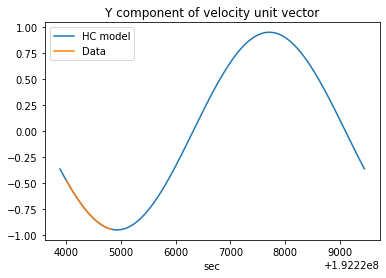

In [215]:
plt.title('Y component of velocity unit vector')
plt.plot(t[0:len(t)-1],v_ECI[:,1], label='HC model')
plt.plot(timeMKF[oldStartMKF:oldStopMKF],velocity[oldStartMKF:oldStopMKF,1],label='Data')
plt.xlabel('sec')
plt.legend()

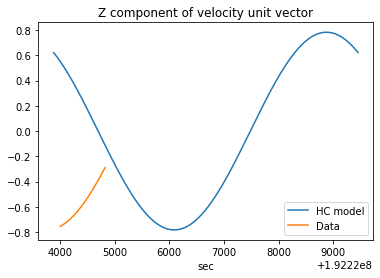

In [216]:
plt.title('Z component of velocity unit vector')
plt.plot(t[0:len(t)-1],v_ECI[:,2], label='HC model')
plt.plot(timeMKF[oldStartMKF:oldStopMKF],velocity[oldStartMKF:oldStopMKF,2],label='Data')
plt.xlabel('sec')
plt.legend()

If velocity is more accurate than position from this original method, we can use velocity as an input to either the pointing vector basis change method and/or $r=v \times h$. This should produce a more accurate position vector.

In [217]:
# Wrote a function to calculate residuals - this function will make life easire in the future
def TwoDVecResid(CalcVec_unit, CalcVec_mag, ExpVec_unit, ExpVec_mag):
    resids_vec = np.zeros((len(ExpVec_mag),3))
    resids_mag = []
    for row in range(len(ExpVec_unit)-1):
        for col in range(3):
            if (type(CalcVec_mag) is int or type(CalcVec_mag) is float):
                resids_vec[row,col] = CalcVec_mag*CalcVec_unit[row,col]-ExpVec_mag[row]*ExpVec_unit[row,col]
            else:
                resids_vec[row,col] = CalcVec_mag[row]*CalcVec_unit[row,col]-ExpVec_mag[row]*ExpVec_unit[row,col]
        resids_mag = np.linalg.norm(resids_vec[row,:])
    return resids_vec, resids_mag

In [218]:
full_position_model = [R*r_ECI[row] for row in range(len(r_ECI))]
full_position_mkf = [position_mag[row]*position[row] for row in range(len(position_mag))]

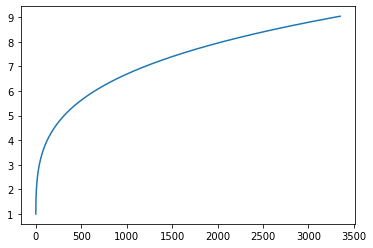

In [219]:
# does this make sense logically??
plt.plot(eccentricity_vec_mag)